In [1]:
import torch
import constants
from tqdm import tqdm
import librosa
import numpy as np
import scipy
import os
import torchaudio
import math
import torch.nn as nn
from torch.cuda import is_available
from torch.utils.data import DataLoader, Dataset, random_split

/home/bozkurtlar/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# File System #
data_loc = "/run/media/bozkurtlar/Acer/Users/Mert/Documents/data"
save_loc = "/home/bozkurtlar/Documents/sound_dl/data/model"


In [3]:
def get_splits() -> dict:
    '''
    Get timings of non silent data for each degree from clean record
    
    Returns:
        Dictionary with timings for each degree. Degree -> Timings array
    '''
    noise_type = "orig"
    snr = "none" # No noise
    degree = list(range(0, 360, constants.degree_step))
 
    timings_dic = dict()
    
    print("Getting non silent audio timings")   
    for degree in tqdm(range(int(360 / constants.degree_step))):
        file_path = os.path.join(data_loc, constants.noise_type[noise_type], constants.SNR[snr],  f"deg_{(degree * constants.degree_step)}.wav")
        signal, _ = torchaudio.load(file_path)
        timings_arr = librosa.effects.split(signal, top_db=40)
        # Join consequent timings if time between is lower than threshold
        for i in range(len(timings_arr) - 1, 0, -1):
            if timings_arr[i][0] - timings_arr[i-1][1] < constants.split_threshold:
                timings_arr[i-1][1] = timings_arr[i][1]
                timings_arr = np.delete(timings_arr, i, 0)
        timings_dic[degree * constants.degree_step] = timings_arr
    return timings_dic

def load_audios(timings_dic: dict) -> list:
    '''
    Load each audio, split out silent parts and add to audios array
    
    Parameters:
        -timings_dict: Dictionary with timings for each degree. Degree -> Timings array
    
    Returns:
        List with audios loaded. (audio, (signal, label))
    '''
    path = data_loc
    noise_type = constants.noise_type_use # Noise types to iterate
    snr = constants.SNR_use # SNR to iterate
    degree = list(range(0, 360, constants.degree_step)) # Degrees to iterate
    length = len(noise_type) * len(snr) * len(degree)
    
    audios = []
    
    print("Starting to load the audios")
    for i in tqdm(range(length)):
        index = handle_index(i, noise_type, snr, degree)
        noise_type_ind, snr_ind, sample_ind = index
        sample_noise_type = noise_type[noise_type_ind]
        sample_snr = snr[snr_ind]
        sample_degree = degree[sample_ind]
        file_path = os.path.join(path, constants.noise_type[sample_noise_type], constants.SNR[sample_snr], f"deg_{sample_degree}.wav")
         
        for timing in timings_dic[sample_degree]:
            frame_offset, num_frames = timing[0], timing[1] - timing[0] 
            signal, sr = torchaudio.load(file_path, frame_offset=frame_offset, num_frames=num_frames)
            audios.append((signal, sample_degree))
    return audios



def preprocess_all_audios(audios: list) -> tuple:
    '''
    Preprocess all audio segments
    
    Parameters:
        -audios: List with audios loaded. (audio, (signal, label))
    
    Returns:
        Tuple with array of phases and labels. (phase_array, label_array)
    '''
    phase_array = []
    label_array = []
    
    print("Starting preprocessing audios")
    for audio in tqdm(audios):
        signal, label = audio
        phase = preprocess_audio_segment(signal)
        split_phase = phase.split(50, dim=2)
        phase_array.extend(split_phase)
        label_array.extend([label for i in range(len(split_phase))])
    print("Preprocessing completed")
    phase_array = torch.stack(phase_array)
    return (phase_array, label_array)

def preprocess_audio_segment(signal: torch.tensor) -> torch.tensor:
    '''
    Helper function for (function) preprocess_all_audios
    
    Parameters:
        -signal: A torch tensor of audio data
        
    Returns:
        The phase array of processed audio
    '''
    phase_array = []
    label_array = []
    num_of_samples = constants.sampling_freq * constants.duration
    signal = cut_audio(signal, num_of_samples)
    signal = add_padding_to_audio(signal, num_of_samples)
    phi = get_phase(signal, constants.sampling_freq, constants.stft_frame_size, constants.stft_hop_size)
    phi = torch.from_numpy(phi)
    return phi

# Helper functions for preprocessing the audio
def get_phase(wave, sampling_freq, stft_frame_size, stft_hop_size):
    f, t, Zxx = scipy.signal.stft(wave,
            fs=sampling_freq,
            window='hann',
            nperseg=stft_frame_size,
            noverlap=stft_hop_size,
            detrend=False,
            return_onesided=True,
            boundary='zeros',
            padded=True)
    
    Zxx = Zxx[:,1:,:500]
    energy = np.abs(Zxx)
    threshold = np.max(energy)/1000; #tolerance threshold
    Zxx[energy < threshold] = 0
    phi = np.angle(Zxx)
    return phi 
        
def cut_audio(signal, num_of_samples):
    if signal.shape[1] > num_of_samples:
        signal = signal[:, :num_of_samples]
    return signal

def add_padding_to_audio(signal, num_of_samples):
    while signal.shape[1] < num_of_samples:
        missing_samples = min(num_of_samples - signal.shape[1], signal.shape[1])
        signal = torch.cat((signal,signal[:,0:missing_samples]), axis=1)
    return signal

def handle_index(index, noise_type, snr, degree):
    '''Returns the folder index for given index'''
    noise_type_ind = math.floor(index / (len(snr) * len(degree)))
    snr_ind = math.floor((index - (noise_type_ind) * (len(snr) * len(degree))) / len(degree))
    sample_ind = math.floor(index - ((noise_type_ind * len(snr)) + snr_ind) * len(degree))
    return (noise_type_ind, snr_ind, sample_ind)

In [ ]:
preprocessed = preprocess_all_audios(load_audios(get_splits()))

Getting non silent audio timings


100%|████████████████████████████████████████████████████████████████████████████████| 72/72 [00:38<00:00,  1.85it/s]


Starting to load the audios


100%|████████████████████████████████████████████████████████████████████████████████| 72/72 [03:50<00:00,  3.19s/it]


Starting preprocessing audios


 43%|████████████████████████████████▊                                           | 1355/3136 [01:00<01:08, 25.87it/s]

In [ ]:
class SoundDataset(Dataset):
    def __init__(self, data, classification=False) -> None:
        super().__init__()
        self.device = 'cuda' if is_available() else 'cpu'
        self.data = data
        self.classification = classification
        self.degree_step = constants.degree_step
    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, index):
        spec, label = self.data
        # If task type is set to classification encode the label in one hot vector
        label = self.encode_label(label[index]) if self.classification else torch.tensor(label[index])
        spec.to(self.device)
        label.to(self.device)
        return spec[index], label
    
    # Encode the label in one-hot vector 
    def encode_label(self, label):
        label = int(label / self.degree_step)
        vector = torch.zeros(int(360 / self.degree_step))
        vector[label] = 1
        return vector
    
dataset = SoundDataset(data=preprocessed, classification=True)

In [ ]:
torch.save(dataset, save_loc, pickle_protocol=4)

In [8]:
class VonMisesLayer(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size):
        super().__init__()
        self.sinConv = nn.Conv2d(input_channel, output_channel, kernel_size, bias=False)
        self.cosConv = nn.Conv2d(input_channel, output_channel, kernel_size, bias=False)
    
    def forward(self, x):
        y_sin = self.sinConv(torch.sin(x))
        y_cos = self.cosConv(torch.cos(x))
        return y_sin + y_cos

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.VonMisesLayer = VonMisesLayer(8, 4, 5)
        self.conv = nn.Conv2d(4, 1, 5)
        self.fc1 = nn.Linear(549, 256)
        self.fc2 = nn.Linear(256, 72)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.sigmoid(self.VonMisesLayer(x)))
        x = self.pool(self.sigmoid(self.conv(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
train_losses = []
val_losses = []

def train_epoch(model, dataloader_train, dataloader_val, optimizer, loss_fn, device):
    '''Trains a single epoch, helper function for (function) train_model'''
    train_loss = 0
    val_loss = 0
    accuracy_correct = 0
    accuracy_total = 0
    for input, target in tqdm(dataloader_train):
        input, target = input.to(device), target.to(device)

        # forward pass
        optimizer.zero_grad()
        prediction = model(input)
        loss = loss_fn(prediction, target)

        # backpropagation
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(dataloader_train)
    train_losses.append(train_loss)
    
    with torch.no_grad():
        for input, target in tqdm(dataloader_val):
            prediction = model(input)
            loss = loss_fn(prediction, target)
            val_loss += loss.item()
            accuracy_correct += len([prediction[i] for i in range(len(prediction)) if prediction[i].argmax() == target[i].argmax()])
            accuracy_total += len(prediction)
        val_loss /= len(dataloader_val)
        val_losses.append(val_loss)
    
    print(f"Train Loss: {train_loss}, Val. Loss: {val_loss}, Accuracy: {(accuracy_correct / accuracy_total) * 100}%")

def train_model(model, dataloader_train, dataloader_val, optimizer, loss_fn, epochs):
    '''Trains the model for all epochs'''
    device = 'cuda' if is_available() else 'cpu'
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        train_epoch(model, dataloader_train, dataloader_val, optimizer, loss_fn, device)
        print("------------------------")
    print("Finished training")


In [11]:
# Define the size of train and test datasets
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

# Perform the train-test split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=False)
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
device = 'cuda' if is_available() else 'cpu'

In [ ]:
try:
    train_model(model, dataloader_train, dataloader_val, optimizer, loss_fn, 60)
except KeyboardInterrupt:
    print("Stopping the training early")

Epoch: 0


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:28<00:00,  5.15it/s]


Train Loss: 0.9698473499531076, Val. Loss: 0.9712009705653807, Accuracy: 67.2406462585034%
------------------------
Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:26<00:00,  5.57it/s]


Train Loss: 0.9147718040382161, Val. Loss: 0.8995658337664442, Accuracy: 68.32482993197279%
------------------------
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:25<00:00,  5.88it/s]


Train Loss: 0.874690880473493, Val. Loss: 0.9092563601578174, Accuracy: 68.55867346938776%
------------------------
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:26<00:00,  5.60it/s]


Train Loss: 0.8354560491703853, Val. Loss: 0.8994195124729961, Accuracy: 69.04761904761905%
------------------------
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:28<00:00,  5.14it/s]


Train Loss: 0.7778266896577586, Val. Loss: 0.7725013565449488, Accuracy: 74.1921768707483%
------------------------
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:29<00:00,  4.99it/s]


Train Loss: 0.7521829965377913, Val. Loss: 0.8156191049789896, Accuracy: 71.93877551020408%
------------------------
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:23<00:00,  6.18it/s]


Train Loss: 0.7067819210518451, Val. Loss: 0.7395560443401337, Accuracy: 74.31972789115646%
------------------------
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:25<00:00,  5.85it/s]


Train Loss: 0.6843547828558112, Val. Loss: 0.7039657462210882, Accuracy: 76.08418367346938%
------------------------
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:30<00:00,  4.89it/s]


Train Loss: 0.6526657183523796, Val. Loss: 0.7954839425427573, Accuracy: 73.08673469387756%
------------------------
Epoch: 9


 26%|████████████████████▉                                                           | 218/833 [01:20<03:35,  2.85it/s]

In [13]:
torch.save(model.state_dict(), "C:\\Users\\Mert\\Documents\\sound_dl\\data\\cnn_classification" + "\\vm_model.pth")

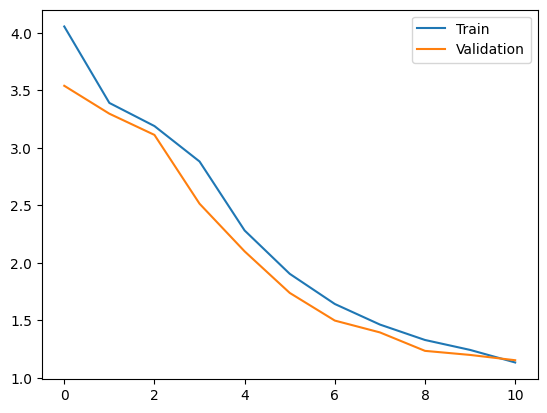

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.show()

In [ ]:
accuracy_dict = {}
len_dict = {}
for i in range(len(preprocessed[1])):
    dta = preprocessed[0][i]
    label = preprocessed[1][i]
    y = model(dta)
    if (abs(label - (y.argmax().item() * 5)) <= 5):
        if label in accuracy_dict:
            accuracy_dict[label] += 1
        else:
            accuracy_dict[label] = 0
    if label in len_dict:
        len_dict[label] += 1
    else:
        len_dict[label] = 0

for i in range(0,360, 5):
    accuracy_dict[i] /= len_dict[i]
    accuracy_dict[i] *= 100

In [ ]:
for key, value in accuracy_dict.items():
    print(f"{key}: {value:.2f}%")

Epoch 35: Train Loss: 0.6227020535632781, Val. Loss: 0.8865342508244557, Accuracy: 79.45066124109867%
Epoch 55: Train Loss: 0.3191727009632078, Val. Loss: 0.44603256916715983, Accuracy: 84.92772108843538%